In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import when
import pandas as pd
from dtreeviz.models.spark_decision_tree import ShadowSparkTree
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.ml.feature import StringIndexer
from sklearn.metrics import ConfusionMatrixDisplay
import traceback
import logging
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import _tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import _tree
import numpy as np
from pyspark.ml import Pipeline

In [2]:
# creation de la Session sous Spark
config = SparkConf()
spark = SparkSession.builder.master("local").appName("test").config(conf=config).getOrCreate()

In [3]:
# Chargement CSV Train
train = spark.read.option("header", "true").csv(r"data\train.csv")
# filtre et supprime les données "NA"
train = train.filter(train.Age != "NA")
train = train.withColumn("Gender", when(train.Sex == "male","1").when(train.Sex == "female","2"))
# Supprime les colonnes inutiles
cols = ('SibSp', 'Parch', 'Fare', 'Ticket' ,'Cabin', 'Embarked', 'Name', 'Sex')
train = train.drop(*cols)

train.show(10)

+-----------+--------+------+---+------+
|PassengerId|Survived|Pclass|Age|Gender|
+-----------+--------+------+---+------+
|          1|       0|     3| 22|     1|
|          2|       1|     1| 38|     2|
|          3|       1|     3| 26|     2|
|          4|       1|     1| 35|     2|
|          5|       0|     3| 35|     1|
|          7|       0|     1| 54|     1|
|          8|       0|     3|  2|     1|
|          9|       1|     3| 27|     2|
|         10|       1|     2| 14|     2|
|         11|       1|     3|  4|     2|
+-----------+--------+------+---+------+
only showing top 10 rows



In [4]:
# Nettoyer les données

train = train.withColumn("PassengerId", train["PassengerId"].cast('float'))
train = train.withColumn("Survived" ,train["Survived"].cast('float'))
train = train.withColumn("Pclass" ,train["Pclass"].cast('float'))
train = train.withColumn("Age" ,train["Age"].cast(('float')))
train = train.withColumn("Gender" ,train["Gender"].cast(('float')))
train.printSchema()
features = ['Pclass','Age', 'Gender']
va = VectorAssembler(inputCols = features, outputCol='features')
va_df = va.transform(train)
va_df.show(3)

root
 |-- PassengerId: float (nullable = true)
 |-- Survived: float (nullable = true)
 |-- Pclass: float (nullable = true)
 |-- Age: float (nullable = true)
 |-- Gender: float (nullable = true)

+-----------+--------+------+----+------+--------------+
|PassengerId|Survived|Pclass| Age|Gender|      features|
+-----------+--------+------+----+------+--------------+
|        1.0|     0.0|   3.0|22.0|   1.0|[3.0,22.0,1.0]|
|        2.0|     1.0|   1.0|38.0|   2.0|[1.0,38.0,2.0]|
|        3.0|     1.0|   3.0|26.0|   2.0|[3.0,26.0,2.0]|
+-----------+--------+------+----+------+--------------+
only showing top 3 rows



In [5]:
#Split des données
(train_, test) = va_df.randomSplit([0.8, 0.2])

In [6]:
# Création du Decision Tree CLassifier
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="Survived")

prediction = dtc.fit(train_)

prediction

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_548eba3dcf50, depth=5, numNodes=27, numClasses=2, numFeatures=3

In [7]:
# la prediction obtenue
pred = prediction.transform(test)
pred = pred.withColumnRenamed('Survived', 'label')
pred.show(3)

+-----------+-----+------+----+------+--------------+-------------+--------------------+----------+
|PassengerId|label|Pclass| Age|Gender|      features|rawPrediction|         probability|prediction|
+-----------+-----+------+----+------+--------------+-------------+--------------------+----------+
|        8.0|  0.0|   3.0| 2.0|   1.0| [3.0,2.0,1.0]|    [9.0,6.0]|           [0.6,0.4]|       0.0|
|       21.0|  0.0|   2.0|35.0|   1.0|[2.0,35.0,1.0]| [219.0,28.0]|[0.88663967611336...|       0.0|
|       22.0|  1.0|   2.0|34.0|   1.0|[2.0,34.0,1.0]| [219.0,28.0]|[0.88663967611336...|       0.0|
+-----------+-----+------+----+------+--------------+-------------+--------------------+----------+
only showing top 3 rows



In [8]:
# la confusion de matrix

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)

print("Prediction Accuracy: ", acc*100)

y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

confusion_M = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(confusion_M)

Prediction Accuracy:  81.31961344656615
Confusion Matrix:
[[85 11]
 [15 30]]


In [9]:
# la confusion de matrix

print(classification_report(y_orig, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87        96
         1.0       0.73      0.67      0.70        45

    accuracy                           0.82       141
   macro avg       0.79      0.78      0.78       141
weighted avg       0.81      0.82      0.81       141



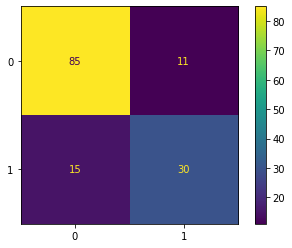

In [10]:
# la confusion de matrix (sous format graphique)
try:
    cm = confusion_matrix(y_orig, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc)
    disp.plot()
except Exception as e:
    print("")
    #logging.error(traceback.format_exc())

In [11]:
# la prediction pour obtenir tous les noeds
prediction._call_java('rootNode').toString()

'InternalNode(prediction = 0.0, impurity = 0.4895089985959206, split = org.apache.spark.ml.tree.ContinuousSplit@fff80000)'

In [12]:
# l'arbre sous format visuel
print(prediction.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_548eba3dcf50, depth=5, numNodes=27, numClasses=2, numFeatures=3
  If (feature 2 <= 1.5)
   If (feature 1 <= 13.5)
    If (feature 0 <= 2.5)
     Predict: 1.0
    Else (feature 0 > 2.5)
     Predict: 0.0
   Else (feature 1 > 13.5)
    If (feature 0 <= 1.5)
     If (feature 1 <= 53.5)
      If (feature 1 <= 47.5)
       Predict: 0.0
      Else (feature 1 > 47.5)
       Predict: 1.0
     Else (feature 1 > 53.5)
      Predict: 0.0
    Else (feature 0 > 1.5)
     Predict: 0.0
  Else (feature 2 > 1.5)
   If (feature 0 <= 2.5)
    If (feature 1 <= 2.5)
     If (feature 0 <= 1.5)
      Predict: 0.0
     Else (feature 0 > 1.5)
      Predict: 1.0
    Else (feature 1 > 2.5)
     Predict: 1.0
   Else (feature 0 > 2.5)
    If (feature 1 <= 38.5)
     If (feature 1 <= 7.5)
      Predict: 1.0
     Else (feature 1 > 7.5)
      If (feature 1 <= 13.5)
       Predict: 0.0
      Else (feature 1 > 13.5)
       Predict: 1.0
    Else (feature 1 > 38

In [13]:
# on stop la session
spark.stop()